### Siddharth Singh 
- siddharthsingh5010@gmail.com
- shashikant.singh501@gmail.com

# Importing Important libraries 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

from scipy import stats
import re
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
import xgboost
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,f1_score

%matplotlib inline
from warnings import filterwarnings
filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\Siddharth\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Loading Train and Test Dataset

In [2]:
df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')

# Creating Combined Dataframe

In [3]:
df_combine=pd.concat([df_train,df_test])

# Exploratory Data Analysis

## Train Dataset 

In [4]:
df_train.shape

(891, 12)

In [5]:
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

There are 177 null values in Age i.e 19.86% and 687 null values in Cabin i.e 77%. We will be imputing Age null records. Since there is high null rate in Cabin so we dropping Cabin column. There are 2 null values in Embarked, we will be imputing them too.


In [6]:
df_train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [7]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

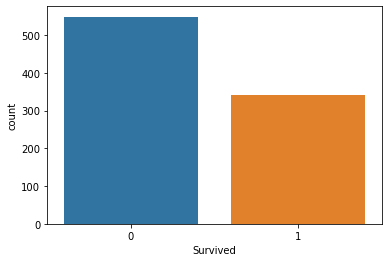

In [8]:
sns.countplot(df_train['Survived']);

There is fair distribution of target class

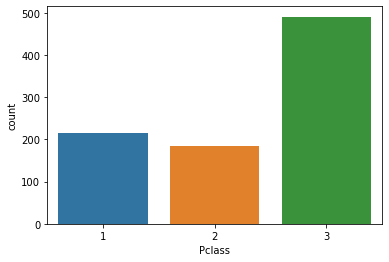

In [9]:
sns.countplot(df_train['Pclass']);

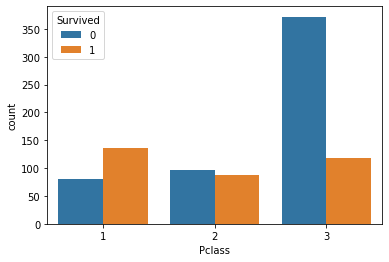

In [10]:
sns.countplot(df_train['Pclass'],hue=df_train['Survived']);

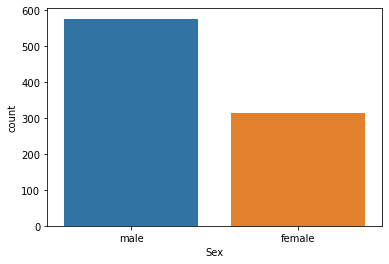

In [11]:
sns.countplot(df_train['Sex']);

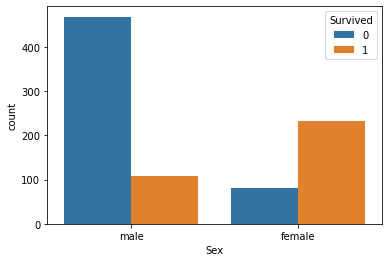

In [12]:
sns.countplot(df_train['Sex'],hue=df_train['Survived']);

Female survived more than male, Proof that many Jacks died for their Roses :D  

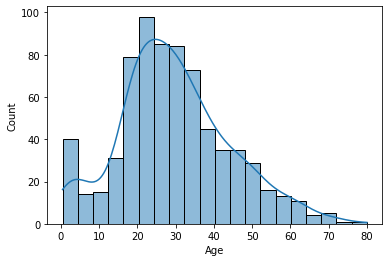

In [13]:
sns.histplot(df_train['Age'],kde=True);

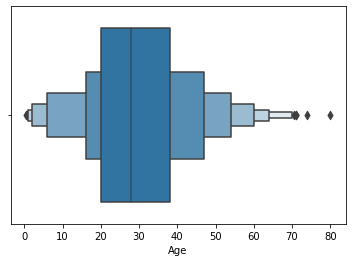

In [14]:
sns.boxenplot(df_train['Age']);

Age is right skewed. We can use box cox transformation to treat this. Also there are outliers present in it which need to be treated

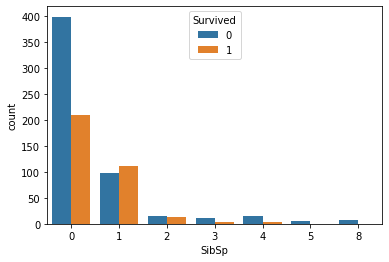

In [15]:
sns.countplot(df_train['SibSp'],hue=df_train['Survived']);

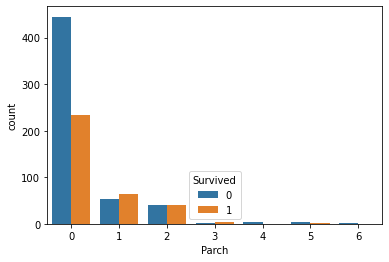

In [16]:
sns.countplot(df_train['Parch'],hue=df_train['Survived']);

High number of passengers are traveling alone. We can create number of relative feature from these two.

In [17]:
df_train.groupby(['Parch']).mean()['Survived']

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64

In [18]:
df_train.groupby(['SibSp']).mean()['Survived']

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64

Also with increasing number of relative there is decline in survival rate.

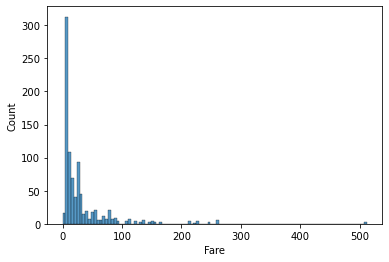

In [19]:
sns.histplot(df_train['Fare']);

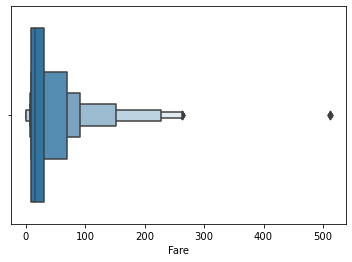

In [20]:
sns.boxenplot(df_train['Fare']);

There are outleirs present in Fare which need to be treated.

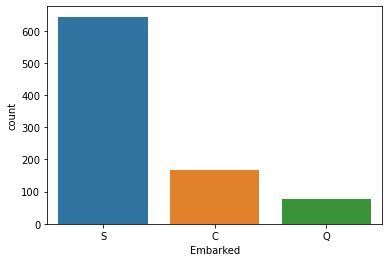

In [21]:
sns.countplot(df_train['Embarked']);

# Extracting Information from Combined Dataset

In [22]:
df_combine.groupby(['Pclass']).median()['Age'].reset_index()

,Pclass,Age
0,1,39.0
1,2,29.0
2,3,24.0


In [23]:
df_combine.groupby(['Pclass','Sex']).median()['Age'].reset_index()

,Pclass,Sex,Age
0,1,female,36.0
1,1,male,42.0
2,2,female,28.0
3,2,male,29.5
4,3,female,22.0
5,3,male,25.0


Both Male and Female age is lower in Pclass 3 and increases toward Pclass 1.

In [24]:
age_median=df_combine['Age'].dropna().median()
age_mean=df_combine['Age'].dropna().mean()
age_std=df_combine['Age'].dropna().std()
fare_median=df_combine['Fare'].dropna().median()
fare_mean=df_combine['Fare'].dropna().mean()
fare_std=df_combine['Fare'].dropna().std()

In [25]:
print('Median Age : {}'.format(age_median))
print('Mean Age : {}'.format(age_mean))
print('Std Age : {}'.format(age_std))
print('Median Fare : {}'.format(fare_median))
print('Mean Fare : {}'.format(fare_mean))
print('Std Fare : {}'.format(fare_std))

Median Age : 28.0
Mean Age : 29.881137667304014
Std Age : 14.413493211271334
Median Fare : 14.4542
Mean Fare : 33.2954792813456
Std Fare : 51.75866823917414


In [26]:
df_combine.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [27]:
df_combine['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [28]:
df_combine.groupby('Embarked').median()['Fare']

Embarked
C    28.51875
Q     7.75000
S    13.00000
Name: Fare, dtype: float64

In [29]:
# Treat Outliers
def treat_outliers(df1,colname,newcolname):
    df=df1.copy()
    Q1,Q3=df[colname].quantile([0.25,0.75])
    IQR=Q3-Q1
    UL=Q3+1.5*IQR
    LL=Q1-1.5*IQR
    df[newcolname]=np.where(df[colname]>UL,UL,df[colname])
    df[newcolname]=np.where(df[colname]<LL,LL,df[colname])
    return df

In [30]:
# Count Letter, Number and Symbols in Ticket 
def lcount(ticket,rtype):
    letter_count=0
    number_count=0
    symbol_count=0
    for character in ticket:
            if character.isalpha():
                letter_count += 1
            elif character.isnumeric():
                number_count += 1
            elif character == " ":
                pass
            else:
                symbol_count += 1
    if rtype==1:
        return letter_count
    elif rtype==2:
        return number_count
    else:
        return symbol_count

# Processing Data Function

In [31]:
def process_data(df1,train=True):
    df=df1.copy() 
    df['Age']=df['Age'].fillna(age_median)
    df['Fare']=df['Fare'].fillna(45) # Imputed Fare more than mean
    df['Embarked'].replace({'Q':1,'S':2,'C':3},inplace=True)
    df['Sex'].replace({'male':1,'female':0},inplace=True)
    df['Embarked'].fillna(2,inplace=True)
    df['family']=df.SibSp+df.Parch+1
    df['pfamily']=df['family']*df['Pclass']
    df['Age*pclass']=df['Age']*df['Pclass']
    
    df['Ticket'].fillna("A",inplace=True)
    df['Ticket_L']=df['Ticket'].apply(lambda x:lcount(x,1))
    df['Ticket_N']=df['Ticket'].apply(lambda x:lcount(x,2))
    df['Ticket_S']=df['Ticket'].apply(lambda x:lcount(x,3))
    
    df['TicketL*embarked']=df['Ticket_L']*df['Embarked']
    df['TicketN*embarked']=df['Ticket_N']*df['Embarked']
    df['TicketS*embarked']=df['Ticket_S']*df['Embarked']

    df['Ticket']=df['Ticket'].apply(lambda x:len(x))
    
    # Treating outliers in Age and Fare
    df=treat_outliers(df,'Age','Age')
    df=treat_outliers(df,'Fare','Fare')

    # Dropping PassengerId, Name and Cabin
    df.drop(['PassengerId','Name','Cabin'],axis=1,inplace=True)
    df=pd.get_dummies(df)
    
    return df

# Train Set 

In [32]:
train=process_data(df_train)

In [33]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,family,pfamily,Age*pclass,Ticket_L,Ticket_N,Ticket_S,TicketL*embarked,TicketN*embarked,TicketS*embarked
0,0,3,1,22.0,1,0,9,7.2500,2.0,2,6,66.0,1,6,1,2.0,12.0,2.0
1,1,1,0,38.0,1,0,8,65.6344,3.0,2,2,38.0,2,5,0,6.0,15.0,0.0
2,1,3,0,26.0,0,0,16,7.9250,2.0,1,3,78.0,5,8,2,10.0,16.0,4.0
3,1,1,0,35.0,1,0,6,53.1000,2.0,2,2,35.0,0,6,0,0.0,12.0,0.0
4,0,3,1,35.0,0,0,6,8.0500,2.0,1,3,105.0,0,6,0,0.0,12.0,0.0


In [34]:
train.isna().sum()

Survived            0
Pclass              0
Sex                 0
Age                 0
SibSp               0
Parch               0
Ticket              0
Fare                0
Embarked            0
family              0
pfamily             0
Age*pclass          0
Ticket_L            0
Ticket_N            0
Ticket_S            0
TicketL*embarked    0
TicketN*embarked    0
TicketS*embarked    0
dtype: int64

# Defining X and y 

In [35]:
X=train.drop('Survived',axis=1)
y=train['Survived']

## Scaling using Standard Scaler

In [36]:
sc=StandardScaler()
X_scaled= pd.DataFrame(sc.fit_transform(X),columns=X.columns)

## Train Test Split

In [37]:
X_train, X_test, y_train, y_test=train_test_split(X_scaled,y,test_size=0.25,random_state=42)

## Make Predictions Function

In [38]:
df_model=pd.DataFrame(columns=['ModelName','Params','TrainAccuracy','TestAccuracy','CVTrain','CVTest','F1Score'])

In [39]:
def make_predictions(model,modelname,params):
    global df_model
    model.fit(X_train,y_train)
    y_train_pred=model.predict(X_train)
    acc_train=accuracy_score(y_train,y_train_pred)
    y_test_pred=model.predict(X_test)
    acc_test=accuracy_score(y_test,y_test_pred)
    CVtrain=np.mean(cross_val_score(model,X_train,y_train,cv=3))
    CVtest=np.mean(cross_val_score(model,X_test,y_test,cv=3))
    F1Score=f1_score(y_test,y_test_pred)
    r={'ModelName':modelname,'Params':params,'TrainAccuracy':acc_train,'TestAccuracy':acc_test,'CVTrain':CVtrain,'CVTest':CVtest,'F1Score':F1Score}
    df_model=df_model.append(r,ignore_index=True)

# RandomForestClassifier

In [40]:
rf_clf=RandomForestClassifier(n_estimators=200,random_state=42)

In [41]:
make_predictions(rf_clf,'RandomForest','n_estimator=200')

In [42]:
df_model

,ModelName,Params,TrainAccuracy,TestAccuracy,CVTrain,CVTest,F1Score
0,RandomForest,n_estimator=200,0.988024,0.780269,0.800913,0.825105,0.723164


# SVM

In [43]:
svm_clf = SVC(gamma="auto")

In [44]:
make_predictions(svm_clf,'SVM','gamma=auto')

In [45]:
df_model

,ModelName,Params,TrainAccuracy,TestAccuracy,CVTrain,CVTest,F1Score
0,RandomForest,n_estimator=200,0.988024,0.780269,0.800913,0.825105,0.723164
1,SVM,gamma=auto,0.83982,0.820628,0.811397,0.807027,0.761905


# SGD

In [46]:
sgd_clf=SGDClassifier()

In [47]:
make_predictions(sgd_clf,'SGD','')

In [48]:
df_model

,ModelName,Params,TrainAccuracy,TestAccuracy,CVTrain,CVTest,F1Score
0,RandomForest,n_estimator=200,0.988024,0.780269,0.800913,0.825105,0.723164
1,SVM,gamma=auto,0.83982,0.820628,0.811397,0.807027,0.761905
2,SGD,,0.785928,0.834081,0.72905,0.712733,0.783626


# Logistic Regression

In [49]:
lr_clf=LogisticRegression()

In [50]:
make_predictions(lr_clf,'Logistic Regression','')

In [51]:
df_model

,ModelName,Params,TrainAccuracy,TestAccuracy,CVTrain,CVTest,F1Score
0,RandomForest,n_estimator=200,0.988024,0.780269,0.800913,0.825105,0.723164
1,SVM,gamma=auto,0.83982,0.820628,0.811397,0.807027,0.761905
2,SGD,,0.785928,0.834081,0.72905,0.712733,0.783626
3,Logistic Regression,,0.806886,0.807175,0.7814,0.806967,0.745562


# XGBoost

In [52]:
xgb_clf=xgboost.XGBClassifier()

In [53]:
make_predictions(xgb_clf,'XGBoost','')

[01:50:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:50:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:50:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:50:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [54]:
df_model

,ModelName,Params,TrainAccuracy,TestAccuracy,CVTrain,CVTest,F1Score
0,RandomForest,n_estimator=200,0.988024,0.780269,0.800913,0.825105,0.723164
1,SVM,gamma=auto,0.83982,0.820628,0.811397,0.807027,0.761905
2,SGD,,0.785928,0.834081,0.72905,0.712733,0.783626
3,Logistic Regression,,0.806886,0.807175,0.7814,0.806967,0.745562
4,XGBoost,,0.98503,0.780269,0.796435,0.816156,0.729282


# KNNClassifier

In [55]:
knn_clf=KNeighborsClassifier()

In [56]:
make_predictions(knn_clf,'KNeighborsClassifier','')

In [57]:
df_model

,ModelName,Params,TrainAccuracy,TestAccuracy,CVTrain,CVTest,F1Score
0,RandomForest,n_estimator=200,0.988024,0.780269,0.800913,0.825105,0.723164
1,SVM,gamma=auto,0.83982,0.820628,0.811397,0.807027,0.761905
2,SGD,,0.785928,0.834081,0.72905,0.712733,0.783626
3,Logistic Regression,,0.806886,0.807175,0.7814,0.806967,0.745562
4,XGBoost,,0.98503,0.780269,0.796435,0.816156,0.729282
5,KNeighborsClassifier,,0.853293,0.7713,0.78445,0.793694,0.715084


# CatBoost Classifier

In [58]:
cat_clf=CatBoostClassifier(silent=True)

In [59]:
make_predictions(cat_clf,'CatBoostClf','')

In [60]:
df_model

,ModelName,Params,TrainAccuracy,TestAccuracy,CVTrain,CVTest,F1Score
0,RandomForest,n_estimator=200,0.988024,0.780269,0.800913,0.825105,0.723164
1,SVM,gamma=auto,0.83982,0.820628,0.811397,0.807027,0.761905
2,SGD,,0.785928,0.834081,0.72905,0.712733,0.783626
3,Logistic Regression,,0.806886,0.807175,0.7814,0.806967,0.745562
4,XGBoost,,0.98503,0.780269,0.796435,0.816156,0.729282
5,KNeighborsClassifier,,0.853293,0.7713,0.78445,0.793694,0.715084
6,CatBoostClf,,0.92515,0.820628,0.814373,0.807087,0.756098


In [61]:
df_model.sort_values('CVTrain',ascending=False)

,ModelName,Params,TrainAccuracy,TestAccuracy,CVTrain,CVTest,F1Score
6,CatBoostClf,,0.92515,0.820628,0.814373,0.807087,0.756098
1,SVM,gamma=auto,0.83982,0.820628,0.811397,0.807027,0.761905
0,RandomForest,n_estimator=200,0.988024,0.780269,0.800913,0.825105,0.723164
4,XGBoost,,0.98503,0.780269,0.796435,0.816156,0.729282
5,KNeighborsClassifier,,0.853293,0.7713,0.78445,0.793694,0.715084
3,Logistic Regression,,0.806886,0.807175,0.7814,0.806967,0.745562
2,SGD,,0.785928,0.834081,0.72905,0.712733,0.783626


CatBoostClassifier is performing better than all others. Top 3 Models are CatBoost,SVM,KNN

# Train Dataset 

In [62]:
test_raw=pd.read_csv('test.csv')

In [63]:
test_df=process_data(test_raw)

In [64]:
sc=StandardScaler()
test_scaled=sc.fit_transform(test_df)

# Ensembling Top 4 Models

In [65]:
testlabels_pred_cat=cat_clf.predict(test_scaled)
testlabels_pred_svm=svm_clf.predict(test_scaled)
testlabels_pred_knn=knn_clf.predict(test_scaled)
testlabels_pred_xgb=xgb_clf.predict(test_scaled)

In [66]:
test_lables=(2*testlabels_pred_cat+1.2*testlabels_pred_svm+1.1*testlabels_pred_xgb+0.7*testlabels_pred_knn)/4

In [67]:
test_lables=np.where(test_lables>0.7,1,0)

In [68]:
test_raw['Survived']=test_lables

In [69]:
test_raw=test_raw[['PassengerId','Survived']]

In [70]:
test_raw.to_csv('Submission_Siddharth.csv',index=False)

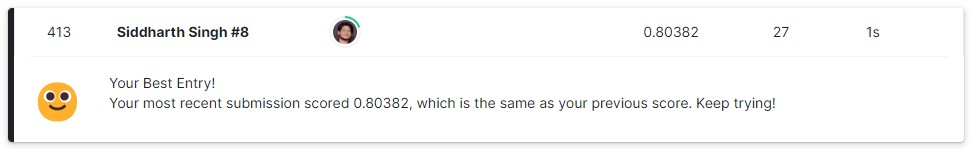

In [71]:
Image(filename='score.jpg') 

# Thank You